In [1]:
# Needed to switch directory in Google drive so as to import CDA env.
from google.colab import drive 
drive.mount('/content/gdrive')
%cd "/content/gdrive/My Drive/Colab Notebooks/gym-continuousDoubleAuction/"
!pwd
!pip install -r requirements.txt
!pip show tensorflow
!pip show ray

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
/content/gdrive/My Drive/Colab Notebooks/gym-continuousDoubleAuction
/content/gdrive/My Drive/Colab Notebooks/gym-continuousDoubleAuction
Obtaining gym_continuousDoubleAuction from git+https://github.com/ChuaCheowHuan/gym-continuousDoubleAuction.git@c897137cbcc93ca71cbd51c27e683c3298f6562d#egg=gym_continuousDoubleAuction (from -r requirements.txt (line 24))
  Skipping because already up-to-date.
  Found existing installation: gym-continuousDoubleAuction 0.0.1
    Can't uninstall 'gym-continuousDoubleAuction'. No files were found to uninstall.
  Running setup.py develop for gym-continuousDoubleAuction
Name: tensorflow
Version: 2.1.0
Summary: TensorFlow is an open source machine learning framework for everyone.
Home-page: https://www.tensorflow.org/
Author: Google Inc.
Author-email: packages@tensorflow.org
License: Apache 2.0
Location: /usr/local/lib/python3.

In [0]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import os
os.environ['RAY_DEBUG_DISABLE_MEMORY_MONITOR'] = "True"

import argparse
import gym
import random
import numpy as np

import ray
from ray import tune
from ray.rllib.utils import try_import_tf
from ray.tune.registry import register_env
from ray.rllib.models import ModelCatalog
from ray.rllib.agents.ppo import ppo
from ray.rllib.agents.ppo.ppo import PPOTrainer
from ray.tune.logger import pretty_print

import sys
if "../" not in sys.path:
    sys.path.append("../")

from gym_continuousDoubleAuction.envs.continuousDoubleAuction_env import continuousDoubleAuctionEnv
from gym_continuousDoubleAuction.train.model.model_handler import CustomModel_1
from gym_continuousDoubleAuction.train.policy.policy_handler import make_RandomPolicy, gen_policy, set_agents_policies
from gym_continuousDoubleAuction.train.weight.weight_handler import get_trained_policies_name, get_max_reward_ind, cp_weight
from gym_continuousDoubleAuction.train.storage.store_handler import create_storage, create_train_policy_list, get_last_eps_steps
from gym_continuousDoubleAuction.train.callbk.callbk_handler import create_step_callbk_list, create_callbk_list, store_user_obs, store_user, store_step_hist, store_hist, access_sample_batches, all_steps_store_obs, all_steps_store, all_eps_store
from gym_continuousDoubleAuction.train.logger.log_handler import callbk_counter, file_num, log_threshold, create_dir, log_json, load_json, log_eps, load_eps
from gym_continuousDoubleAuction.train.plotter.plot_handler import plot_steps, plot_eps, show_obs, plot_last_eps_steps

tf = try_import_tf()

In [3]:
# global

# CDA_env args
num_agents = 10
num_trained_agent = 2 # 1st 2
num_policies = num_agents # Each agent is using a separate policy
num_of_traders = num_agents
tape_display_length = 10 
tick_size = 1
init_cash = 1000000
max_step = 1000 # per episode, -1 in arg. (7.2s/1000steps/iter)
is_render = False

# step storages
obs_step_store = create_storage(num_agents, "agt_", "_obs_step_list")
reward_step_store = create_storage(num_agents, "agt_", "_reward_step_list")
NAV_step_store = create_storage(num_agents, "agt_", "_NAV_step_list")
num_trades_step_store = create_storage(num_agents, "agt_", "_num_trades_step_list")

# episodic storages
policy_reward_store = create_storage(num_agents, "agt_", "_policy_reward_list")
reward_store = create_storage(num_agents, "agt_", "_reward_list")
NAV_store = create_storage(num_agents, "agt_", "_NAV_list")
num_trades_store = create_storage(num_agents, "agt_", "_num_trades_list")

# storage for json input
obs_store = create_storage(num_agents, "agt_", "_obs_list")
act_store = create_storage(num_agents, "agt_", "_act_list")
infos_store = create_storage(num_agents, "agt_", "_infos_list")

# RLlib config 
train_policy_list = create_train_policy_list(num_trained_agent, "policy_")
num_workers = 1
num_envs_per_worker = 2
sample_batch_size = 32
train_batch_size = 128
num_iters = 150
log_dir="/content/gdrive/My Drive/Colab Notebooks/gym-continuousDoubleAuction/gym_continuousDoubleAuction/ray_results/"

# Chkpt & restore
local_dir="/content/gdrive/My Drive/Colab Notebooks/gym-continuousDoubleAuction/gym_continuousDoubleAuction/chkpt/"
chkpt_freq = 10
chkpt = 450
restore_path = "{}checkpoint_{}/checkpoint-{}".format(local_dir, chkpt, chkpt)
is_restore = False

# log & load 
write_last_eps_steps_dir="/content/gdrive/My Drive/Colab Notebooks/gym-continuousDoubleAuction/gym_continuousDoubleAuction/last_eps_steps/"
write_eps_dir="/content/gdrive/My Drive/Colab Notebooks/gym-continuousDoubleAuction/gym_continuousDoubleAuction/eps/"
create_dir(write_last_eps_steps_dir)    
create_dir(write_eps_dir)    
threshold = log_threshold(num_workers, num_envs_per_worker, num_iters, num_agents)
print("threshold", threshold)

# get obs & act spaces from dummy CDA env
single_CDA_env = continuousDoubleAuctionEnv(num_of_traders, init_cash, tick_size, tape_display_length, max_step, is_render)
obs_space = single_CDA_env.observation_space
act_space = single_CDA_env.action_space

# register CDA env with RLlib 
register_env("continuousDoubleAuction-v0", lambda _: continuousDoubleAuctionEnv(num_of_traders, 
                                                                                init_cash, 
                                                                                tick_size, 
                                                                                tape_display_length,
                                                                                max_step-1, 
                                                                                is_render))

# register custom model (neural network)
ModelCatalog.register_custom_model("model_disc", CustomModel_1) 

# start ray
ray.init(ignore_reinit_error=True, log_to_driver=True, webui_host='127.0.0.1', num_cpus=2) 

/usr/local/lib/python3.6/dist-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))
2020-04-02 13:47:49,326	WARNING services.py:586 -- setpgrp failed, processes may not be cleaned up properly: [Errno 1] Operation not permitted.
2020-04-02 13:47:49,330	INFO resource_spec.py:212 -- Starting Ray with 7.13 GiB memory available for workers and up to 3.58 GiB for objects. You can adjust these settings with ray.init(memory=<bytes>, object_store_memory=<bytes>).


train_policy_list =  ['policy_0', 'policy_1']
Folder created: /content/gdrive/My Drive/Colab Notebooks/gym-continuousDoubleAuction/gym_continuousDoubleAuction/last_eps_steps/
Folder created: /content/gdrive/My Drive/Colab Notebooks/gym-continuousDoubleAuction/gym_continuousDoubleAuction/eps/
num_eps 300
threshold 1490


2020-04-02 13:47:49,778	INFO services.py:1078 -- View the Ray dashboard at 127.0.0.1:8265


{'node_ip_address': '172.28.0.2',
 'object_store_address': '/tmp/ray/session_2020-04-02_13-47-49_325725_645/sockets/plasma_store',
 'raylet_socket_name': '/tmp/ray/session_2020-04-02_13-47-49_325725_645/sockets/raylet',
 'redis_address': '172.28.0.2:12039',
 'session_dir': '/tmp/ray/session_2020-04-02_13-47-49_325725_645',
 'webui_url': '127.0.0.1:8265'}

In [4]:
# Dictionary of policies
policies = {"policy_{}".format(i): gen_policy(i, obs_space, act_space) for i in range(num_policies)}
set_agents_policies(policies, obs_space, act_space, num_agents, num_trained_agent)
policy_ids = list(policies.keys())

def policy_mapper(agent_id):
    """
    Required in RLlib config.
    """
    for i in range(num_agents):
        if agent_id == i:
            return "policy_{}".format(i)

policies: {'policy_0': (None, Box(4, 10), Tuple(Discrete(3), Discrete(4), Box(1,), Box(1,), Discrete(12)), {}), 'policy_1': (None, Box(4, 10), Tuple(Discrete(3), Discrete(4), Box(1,), Box(1,), Discrete(12)), {}), 'policy_2': (<class 'gym_continuousDoubleAuction.train.policy.policy_handler.make_RandomPolicy.<locals>.RandomPolicy'>, Box(4, 10), Tuple(Discrete(3), Discrete(4), Box(1,), Box(1,), Discrete(12)), {}), 'policy_3': (<class 'gym_continuousDoubleAuction.train.policy.policy_handler.make_RandomPolicy.<locals>.RandomPolicy'>, Box(4, 10), Tuple(Discrete(3), Discrete(4), Box(1,), Box(1,), Discrete(12)), {}), 'policy_4': (<class 'gym_continuousDoubleAuction.train.policy.policy_handler.make_RandomPolicy.<locals>.RandomPolicy'>, Box(4, 10), Tuple(Discrete(3), Discrete(4), Box(1,), Box(1,), Discrete(12)), {}), 'policy_5': (<class 'gym_continuousDoubleAuction.train.policy.policy_handler.make_RandomPolicy.<locals>.RandomPolicy'>, Box(4, 10), Tuple(Discrete(3), Discrete(4), Box(1,), Box(1,),

In [0]:
def on_episode_start(info):
    """
    info["episode"] is a MultiAgentEpisode object.
    """

    episode = info["episode"] 
    #print("on_episode_end episode_id={}, length={}".format(episode.episode_id, episode.length))

    create_step_callbk_list(num_agents, episode, "_obs_step")

    create_step_callbk_list(num_agents, episode, "_reward_step")
    create_step_callbk_list(num_agents, episode, "_NAV_step")
    create_step_callbk_list(num_agents, episode, "_num_trades_step")

    create_callbk_list(num_agents, episode, "_reward")
    create_callbk_list(num_agents, episode, "_NAV")
    create_callbk_list(num_agents, episode, "_num_trades")

In [0]:
def on_episode_step(info):
    episode = info["episode"]

    store_user_obs(num_agents, episode, "_obs_step", "obs")

    store_user(num_agents, episode, "_reward_step", "reward")
    store_user(num_agents, episode, "_NAV_step", "NAV")
    store_user(num_agents, episode, "_num_trades_step", "num_trades")             

In [0]:
def on_episode_end(info):
    """
    arg: {"env": .., "episode": ...}
    """

    episode = info["episode"]

    #store_step_hist(episode, "_obs_step")

    store_step_hist(num_agents, episode, "_reward_step")
    store_step_hist(num_agents, episode, "_NAV_step")
    store_step_hist(num_agents, episode, "_num_trades_step")     

    store_hist(num_agents, episode, "reward")
    store_hist(num_agents, episode, "NAV")
    store_hist(num_agents, episode, "num_trades")

In [0]:
def on_sample_end(info):
    """
    arg: {"samples": .., "worker": ...}
    """

    """
    Notes:
        https://github.com/ray-project/ray/blob/master/rllib/policy/sample_batch.py
    """
    MultiAgentBatch_obj = info["samples"]
    MultiAgentBatch_policy_batches = MultiAgentBatch_obj.policy_batches
    MultiAgentBatch_count = MultiAgentBatch_obj.count

    #access_sample_batches(MultiAgentBatch_policy_batches)
    #print("info['samples'].policy_batches = {}".format(info["samples"].policy_batches))
    #print("info['worker'] = {}".format(info["worker"])) # RolloutWorker object

In [0]:
def on_train_result(info):
    """
    info["trainer"] is the trainer object.

    info["result"] contains a bunch of info such as episodic rewards 
    for each policy in info["result"][hist_stats] dictionary.
    """

    # you can mutate the result dict to add new fields to return
    info["result"]["callback_ok"] = True
    
    train_policies_name = get_trained_policies_name(policies, num_trained_agent)    
    max_reward_ind = get_max_reward_ind(info, train_policies_name)
    max_reward_policy_name = train_policies_name[max_reward_ind]
    cp_weight(info["trainer"], train_policies_name, max_reward_policy_name)    

    #all_steps_store_obs(info, obs_step_store, "agt_", "_obs_step", "_obs_step_list = {}")     

    all_steps_store(info, reward_step_store, "agt_", "_reward_step", "_reward_step_list = {}")     
    all_steps_store(info, NAV_step_store, "agt_", "_NAV_step", "_NAV_step_list = {}")     
    all_steps_store(info, num_trades_step_store, "agt_", "_num_trades_step", "_num_trades_step_list = {}")     

    all_eps_store(info, policy_reward_store, "policy_policy_", "_reward", "_policy_reward_list[0] = {}")    
    all_eps_store(info, reward_store, "agt_", "_reward", "_reward_list[0] = {}") 
    all_eps_store(info, NAV_store, "agt_", "_NAV", "_NAV_list[0] = {}") 
    all_eps_store(info, num_trades_store, "agt_", "_num_trades", "_num_trades_list[0] = {}") 

    #print("on_train_result info['result'] {}".format(info["result"]))     

In [0]:
def on_postprocess_traj(info):
    """
    arg: {"agent_id": ..., "episode": ...,
          "pre_batch": (before processing),
          "post_batch": (after processing),
          "all_pre_batches": (other agent ids),
          }

    # https://github.com/ray-project/ray/blob/ee8c9ff7320ec6a2d7d097cd5532005c6aeb216e/rllib/policy/sample_batch.py
    Dictionaries in a sample_obj, k:
        t
        eps_id
        agent_index
        obs
        actions
        rewards
        prev_actions
        prev_rewards
        dones
        infos
        new_obs
        action_prob
        action_logp
        vf_preds
        behaviour_logits
        unroll_id       
    """
    #policy_obj = info["pre_batch"][0]
    sample_obj = info["pre_batch"][1]    
    agt_id = info["agent_id"]
    eps_id = info["episode"].episode_id

    # log steps for last episode for each agent
    global callbk_counter
    if callbk_counter >= threshold:
        log_json(agt_id, eps_id, sample_obj, write_last_eps_steps_dir)
        print("on_postprocess_traj log_json callbk_counter = {}".format(callbk_counter))
    #else:        
    #    print("on_postprocess_traj callbk_counter = {}".format(callbk_counter))

    callbk_counter = callbk_counter + 1

    return

In [0]:
def get_config():
    config = ppo.DEFAULT_CONFIG.copy()
    config["multiagent"] = {"policies_to_train": train_policy_list,
                            "policies": policies,
                            "policy_mapping_fn": policy_mapper,
                           }    
    config["num_workers"] = num_workers
    config["num_envs_per_worker"] = num_envs_per_worker  
    config["batch_mode"] = "complete_episodes"
    config["train_batch_size"] = train_batch_size # Training batch size, if applicable. Should be >= rollout_fragment_length.
                                                  # Samples batches will be concatenated together to a batch of this size,
                                                  # which is then passed to SGD.
    config["sample_batch_size"] = sample_batch_size # DEPRECATED_VALUE,
    config["log_level"] = "WARN"
    config["callbacks"] = {"on_episode_start": on_episode_start, 
                           "on_episode_step": on_episode_step, 
                           "on_episode_end": on_episode_end, 
                           "on_sample_end": on_sample_end,
                           "on_postprocess_traj": on_postprocess_traj,
                           "on_train_result": on_train_result,}
    config["output"] = log_dir

    return config


In [12]:
# Training

def go_train(config):    
    trainer = ppo.PPOTrainer(config=config, env="continuousDoubleAuction-v0")
    
    if is_restore == True:
        trainer.restore(restore_path) 
    
    result = None
    for i in range(num_iters):
        result = trainer.train()       
        print("training loop = {} of {}".format(i + 1, num_iters))            
        
        if i % chkpt_freq == 0:
            checkpoint = trainer.save(local_dir)
            print("checkpoint saved at", checkpoint)
    
    checkpoint = trainer.save(local_dir)
    print("checkpoint saved at", checkpoint)
    print(pretty_print(result)) # includes result["custom_metrics"]


# run everything
go_train(get_config())            

2020-04-02 13:47:50,985	INFO trainer.py:420 -- Tip: set 'eager': true or the --eager flag to enable TensorFlow eager execution
2020-04-02 13:47:51,162	INFO trainer.py:580 -- Current log_level is WARN. For more information, set 'log_level': 'INFO' / 'DEBUG' or use the -v and -vv flags.
/usr/local/lib/python3.6/dist-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))
/usr/local/lib/python3.6/dist-packages/ray/rllib/utils/from_config.py:134: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  obj = yaml.load(type_)


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unexpected EOF while parsing (<unknown>, line 5)
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unexpected EOF while parsing (<unknown>, line 5)


/usr/local/lib/python3.6/dist-packages/ray/rllib/utils/from_config.py:134: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  obj = yaml.load(type_)


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unexpected EOF while parsing (<unknown>, line 5)
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unexpected EOF while parsing (<unknown>, line 5)


/usr/local/lib/python3.6/dist-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unexpected EOF while parsing (<unknown>, line 5)
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unexpected EOF while parsing (<unknown>, line 5)
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unexpected EOF while parsing (<unknown>, line 5)
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unexpected EOF while parsing (<unknown>, line 5)
(pid=733) /usr/local/lib/python3.6/dist-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32


2020-04-02 13:48:10,028	INFO trainable.py:178 -- _setup took 18.876 seconds. If your trainable is slow to initialize, consider setting reuse_actors=True to reduce actor creation overheads.
2020-04-02 13:48:10,030	WARNING util.py:37 -- Install gputil for GPU system monitoring.


training loop = 1 of 150
checkpoint saved at /content/gdrive/My Drive/Colab Notebooks/gym-continuousDoubleAuction/gym_continuousDoubleAuction/chkpt/checkpoint_1/checkpoint-1
training loop = 2 of 150
training loop = 3 of 150
training loop = 4 of 150
training loop = 5 of 150
training loop = 6 of 150
training loop = 7 of 150
training loop = 8 of 150
training loop = 9 of 150
training loop = 10 of 150
training loop = 11 of 150
checkpoint saved at /content/gdrive/My Drive/Colab Notebooks/gym-continuousDoubleAuction/gym_continuousDoubleAuction/chkpt/checkpoint_11/checkpoint-11
training loop = 12 of 150
training loop = 13 of 150
training loop = 14 of 150
training loop = 15 of 150
training loop = 16 of 150
training loop = 17 of 150
training loop = 18 of 150
training loop = 19 of 150
training loop = 20 of 150
training loop = 21 of 150
checkpoint saved at /content/gdrive/My Drive/Colab Notebooks/gym-continuousDoubleAuction/gym_continuousDoubleAuction/chkpt/checkpoint_21/checkpoint-21
training loo

# All steps from all episodes.

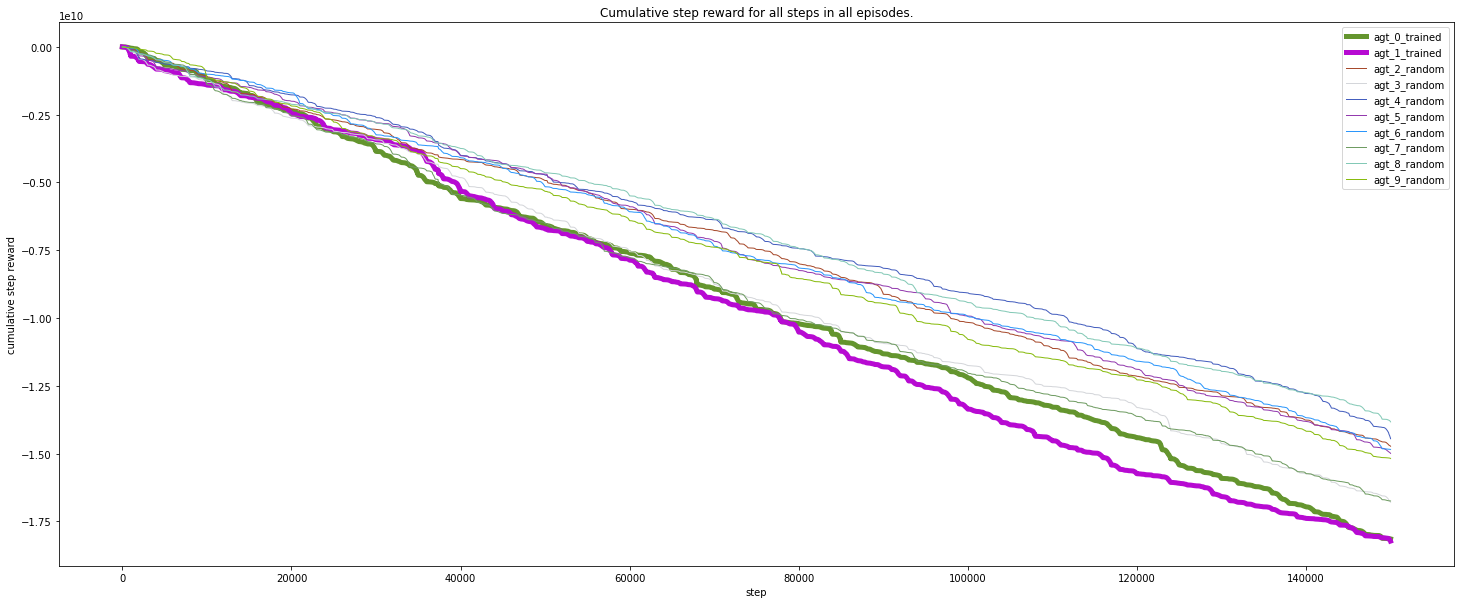

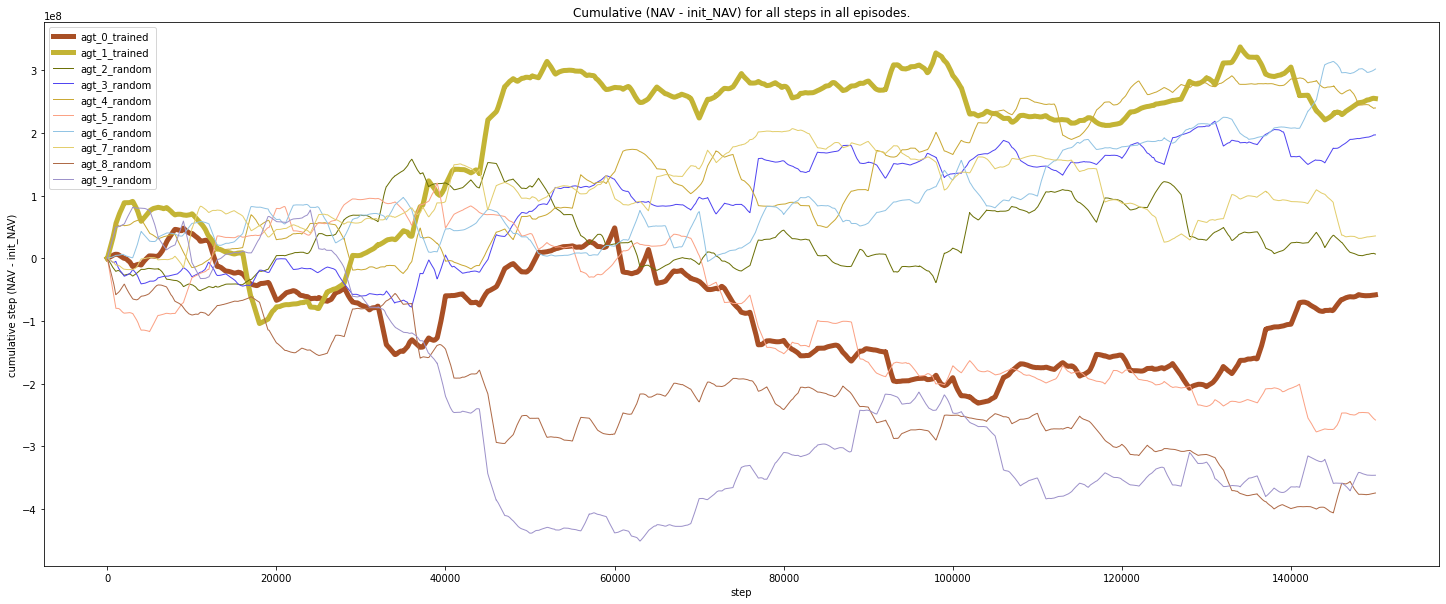

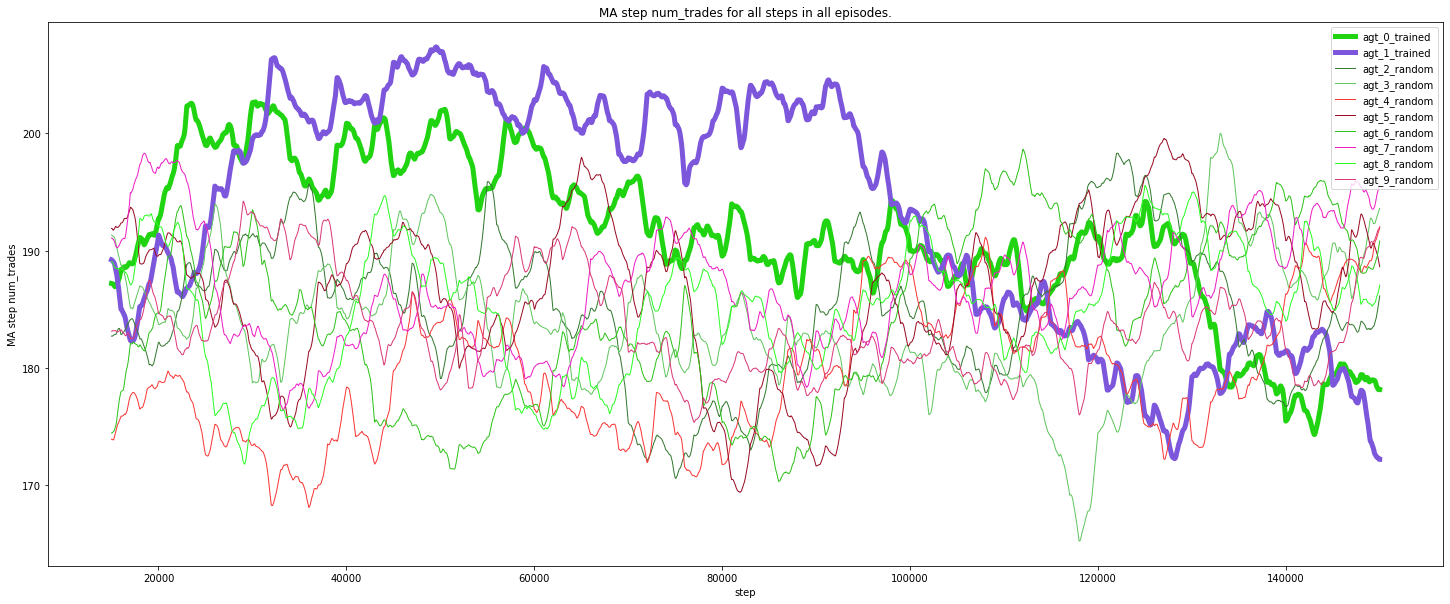

In [13]:
# Plot step results
plot_steps(init_cash, num_agents, num_trained_agent, "reward", reward_step_store, 'agt_', '_reward_step_list', '_trained', 'step', 'cumulative step reward', 'Cumulative step reward for all steps in all episodes.')
plot_steps(init_cash, num_agents, num_trained_agent, "NAV", NAV_step_store, 'agt_', '_NAV_step_list', '_trained', 'step', 'cumulative step (NAV - init_NAV)', 'Cumulative (NAV - init_NAV) for all steps in all episodes.')
plot_steps(init_cash, num_agents, num_trained_agent, "num_trades", num_trades_step_store, 'agt_', '_num_trades_step_list', '_trained', 'step', 'MA step num_trades', 'MA step num_trades for all steps in all episodes.') 

# Episodes

In [0]:
# Log episodes data to json files.
log_eps(write_eps_dir, "policy_reward", policy_reward_store)
log_eps(write_eps_dir, "reward", reward_store)
log_eps(write_eps_dir, "NAV", NAV_store)
log_eps(write_eps_dir, "num_trades", num_trades_store)

In [0]:
# Load episodes data from json files to dictionaries.
policy_reward_store = load_eps(write_eps_dir, 'policy_reward.dat', policy_reward_store)
reward_store = load_eps(write_eps_dir, 'reward.dat', reward_store)
NAV_store = load_eps(write_eps_dir, 'NAV.dat', NAV_store)
num_trades_store = load_eps(write_eps_dir, 'num_trades.dat', num_trades_store)

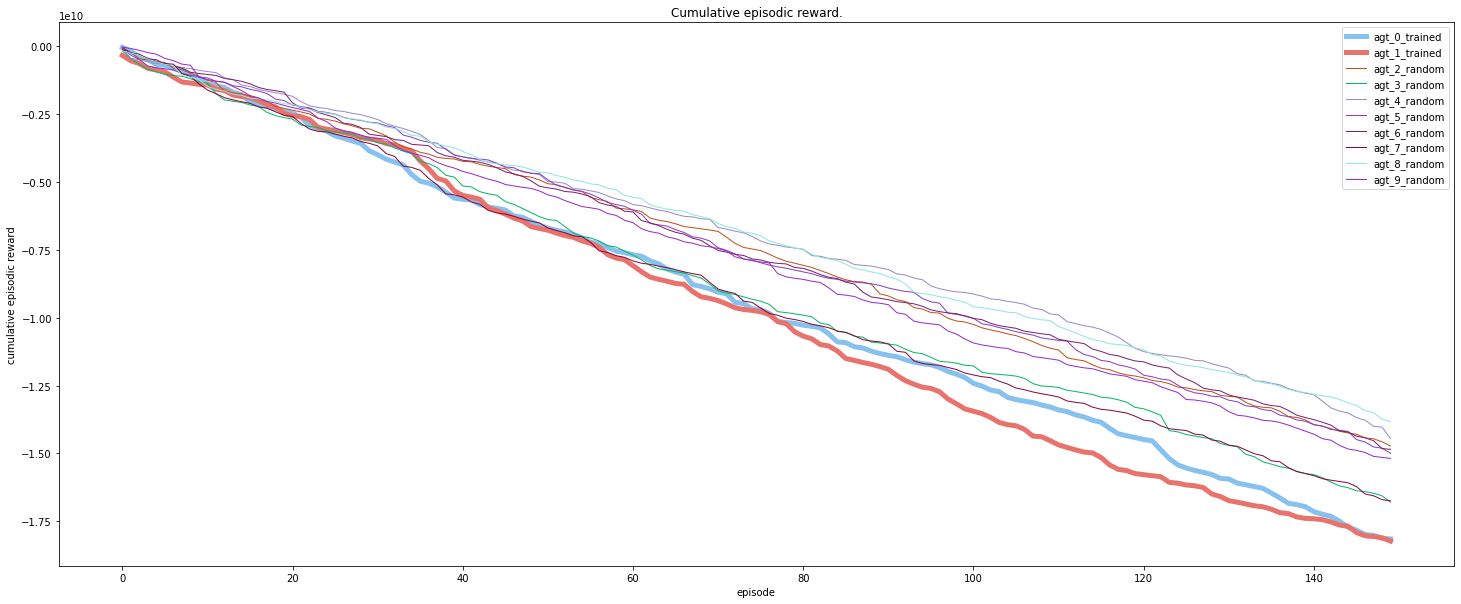

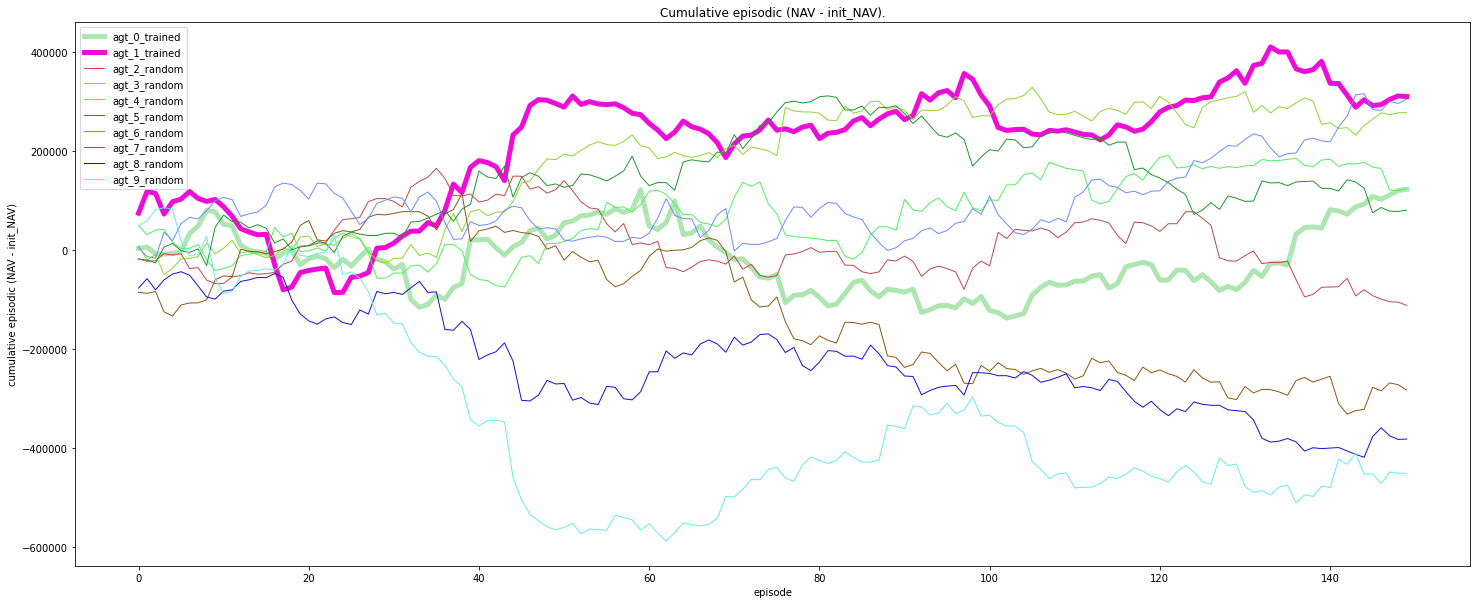

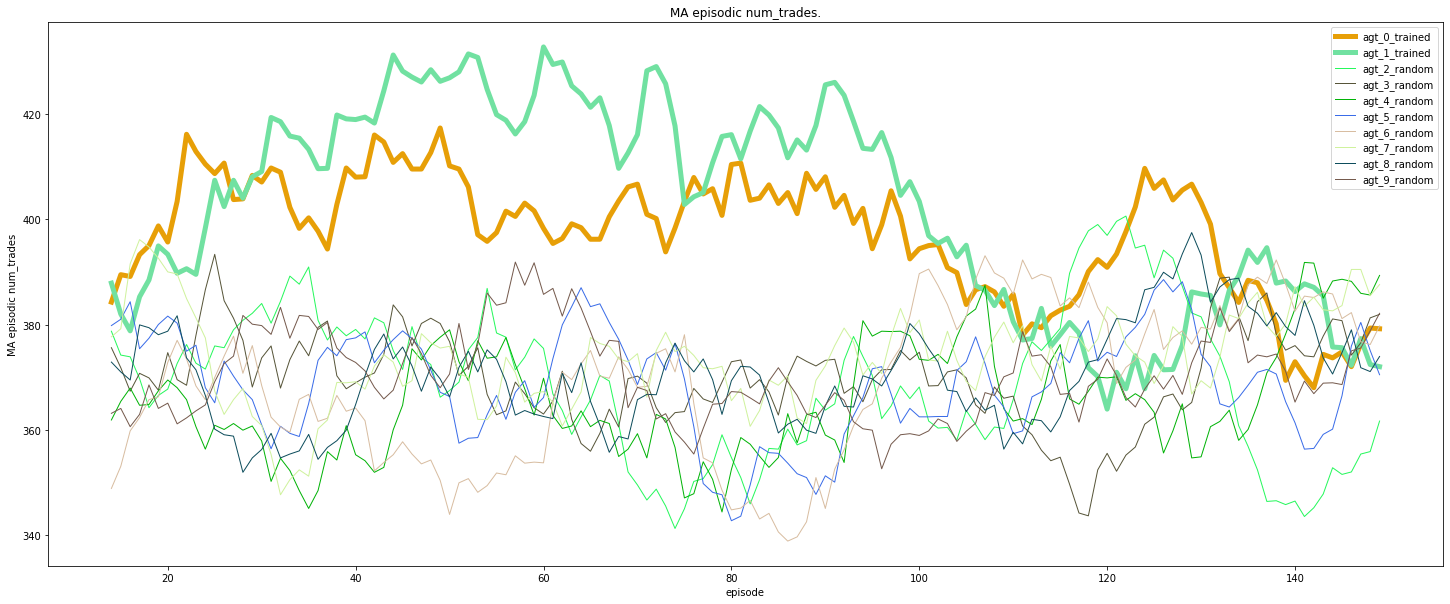

In [16]:
# Plot episodic results
plot_eps(init_cash, num_agents, num_trained_agent, "reward", policy_reward_store, 'agt_', '_policy_reward_list', '_trained', 'episode','cumulative episodic reward', 'Cumulative episodic reward.')
#plot_eps(init_cash, num_agents, num_trained_agent, "reward", reward_store, 'agt_', '_reward_list', '_trained', 'episode','cumulative episodic raw reward', 'Last step raw reward, unlike policy_reward_store which is total reward/eps.') # last step raw reward, unlike policy_reward_store which is total reward/eps.
plot_eps(init_cash, num_agents, num_trained_agent, "NAV", NAV_store, 'agt_', '_NAV_list', '_trained', 'episode','cumulative episodic (NAV - init_NAV)', 'Cumulative episodic (NAV - init_NAV).')
plot_eps(init_cash, num_agents, num_trained_agent, "num_trades", num_trades_store, 'agt_', '_num_trades_list', '_trained', 'episode','MA episodic num_trades', 'MA episodic num_trades.')   

# Steps from last episode.

In [17]:
"""
obs_store = create_storage(num_agents, "agt_", "_obs_list")
act_store = create_storage(num_agents, "agt_", "_act_list")
infos_store = create_storage(num_agents, "agt_", "_infos_list")
"""

# load last episode for all agents
load_json(write_last_eps_steps_dir, max_step, obs_store, act_store, infos_store)

0_0_219845064.dat
1_1_219845064.dat
2_2_219845064.dat
3_3_219845064.dat
4_4_219845064.dat
5_5_219845064.dat
6_6_219845064.dat
7_7_219845064.dat
8_8_219845064.dat
9_9_219845064.dat


In [0]:
reward_dict = get_last_eps_steps(num_agents, 'reward', infos_store, 'agt_', '_infos_list')
NAV_dict = get_last_eps_steps(num_agents, 'NAV', infos_store, 'agt_', '_infos_list')
num_trades_dict = get_last_eps_steps(num_agents, 'num_trades', infos_store, 'agt_', '_infos_list')

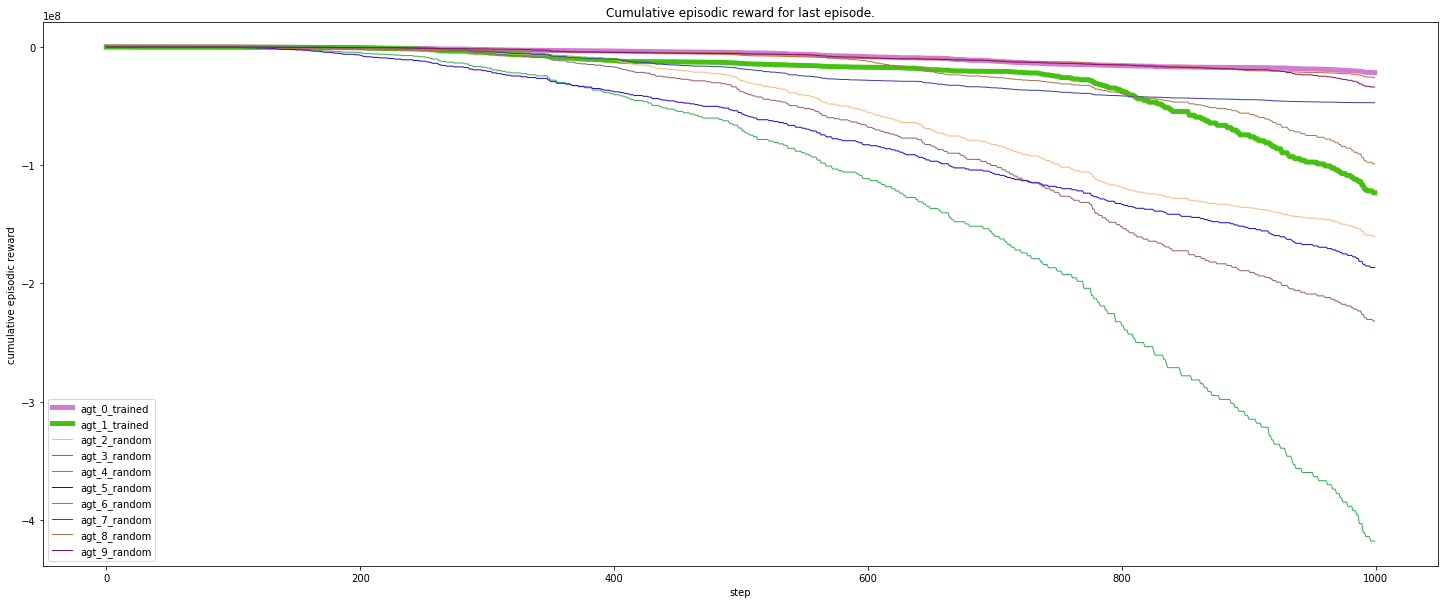

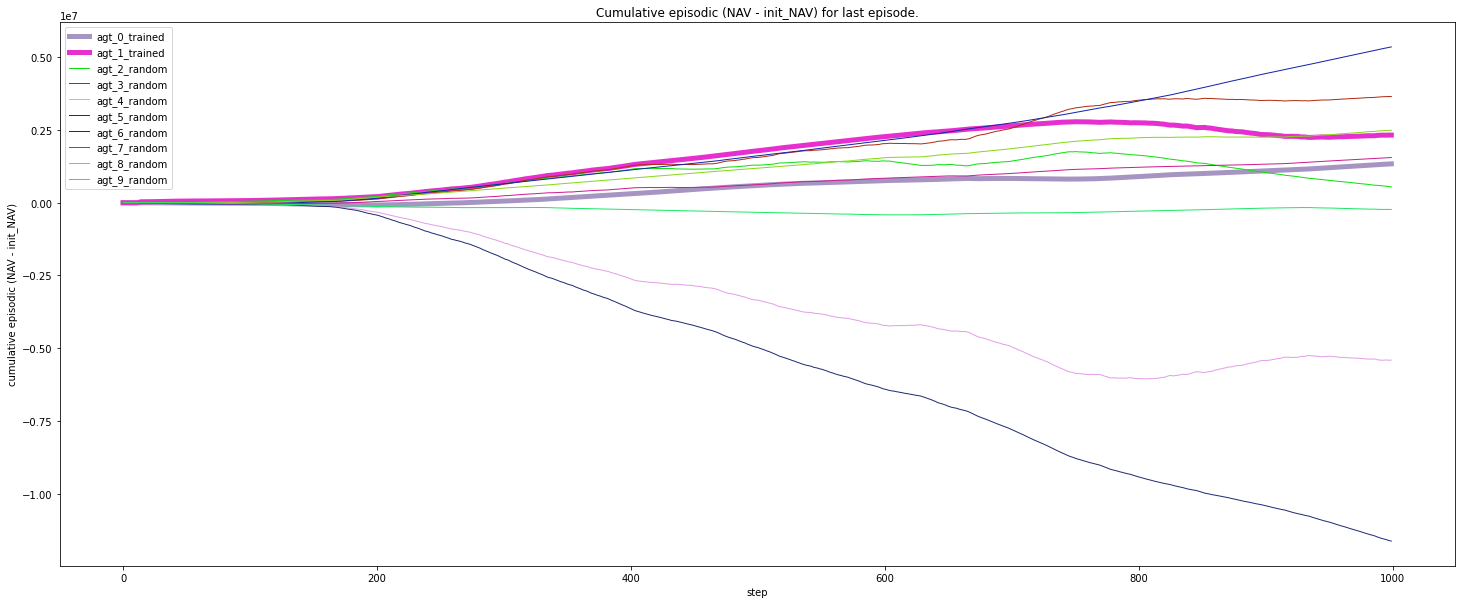

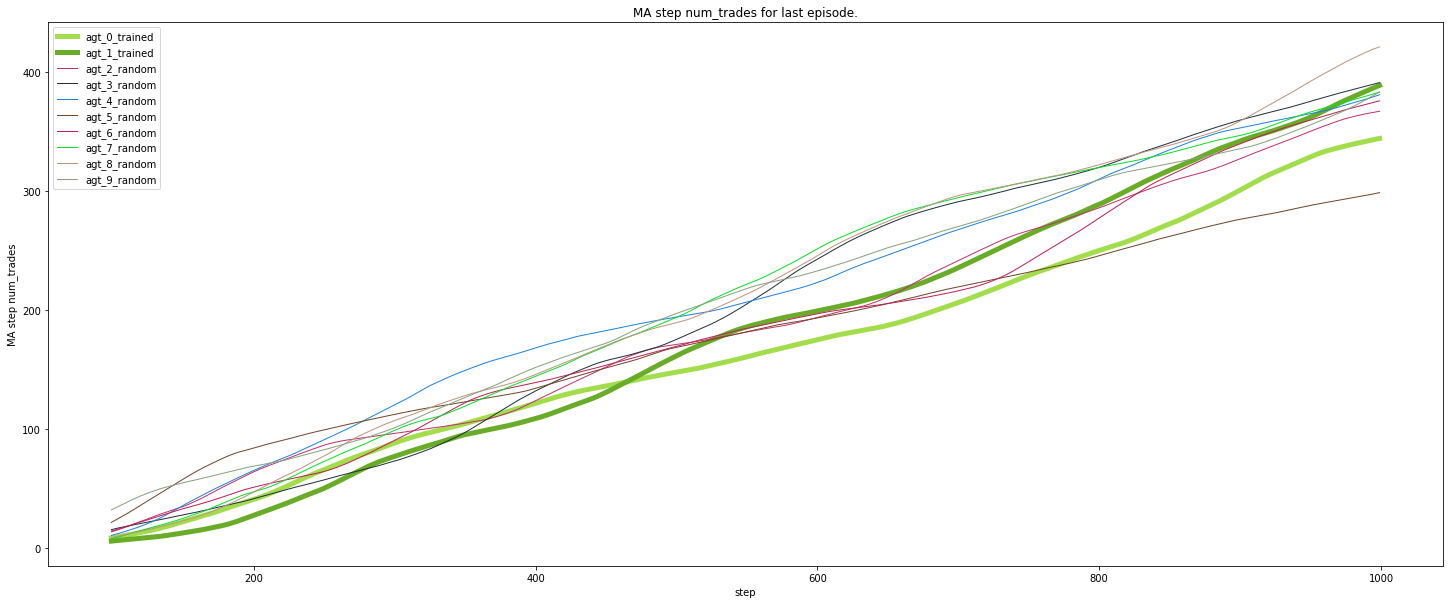

In [19]:
plot_last_eps_steps(reward_dict, num_trained_agent, 'reward', init_cash, "agt_", "reward_dict", "_trained", 'cumulative episodic reward', 'Cumulative episodic reward for last episode.')    
plot_last_eps_steps(NAV_dict, num_trained_agent, 'NAV', init_cash, "agt_", "NAV_dict", "_trained", 'cumulative episodic (NAV - init_NAV)', 'Cumulative episodic (NAV - init_NAV) for last episode.')  
plot_last_eps_steps(num_trades_dict, num_trained_agent, 'num_trades', init_cash, "agt_", "num_trades_dict", "_trained", 'MA step num_trades', 'MA step num_trades for last episode.')      

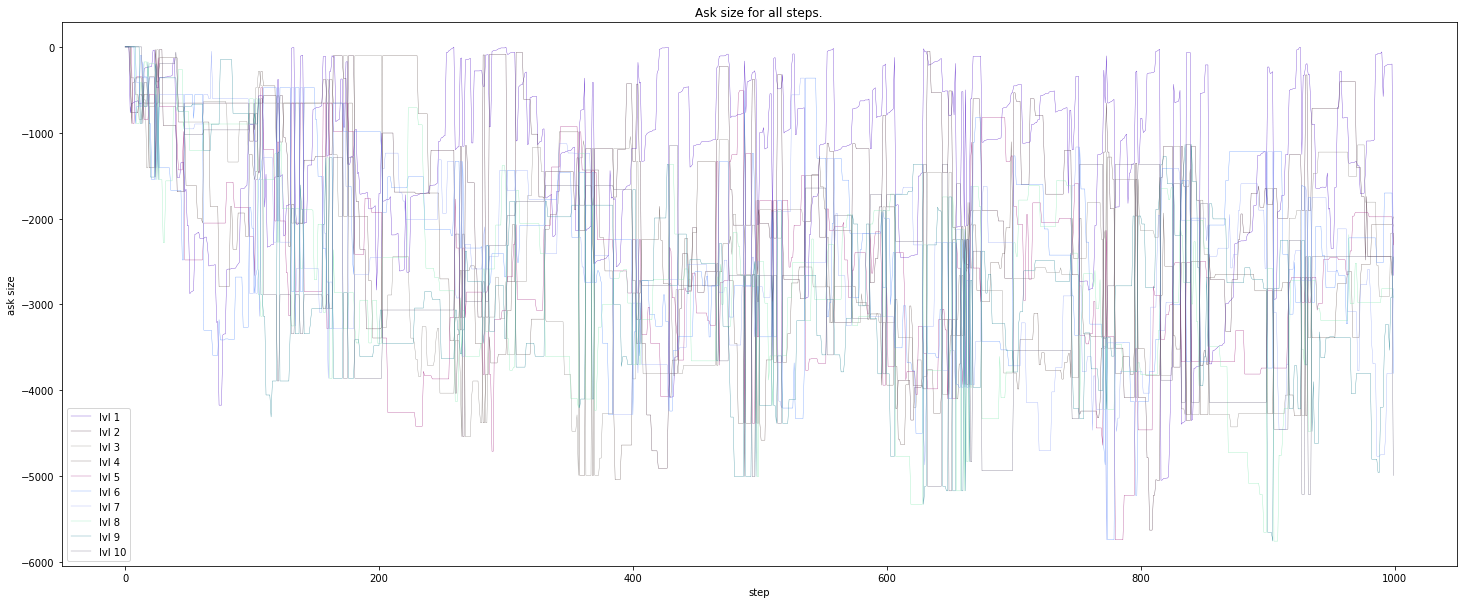

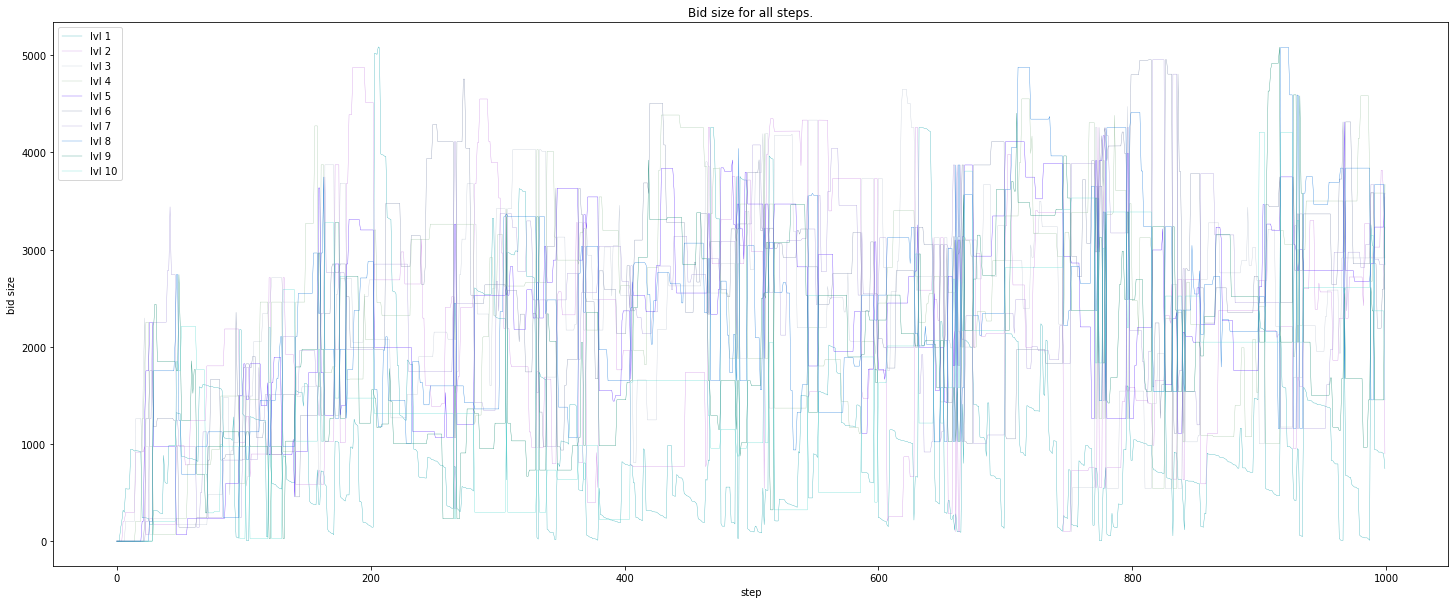

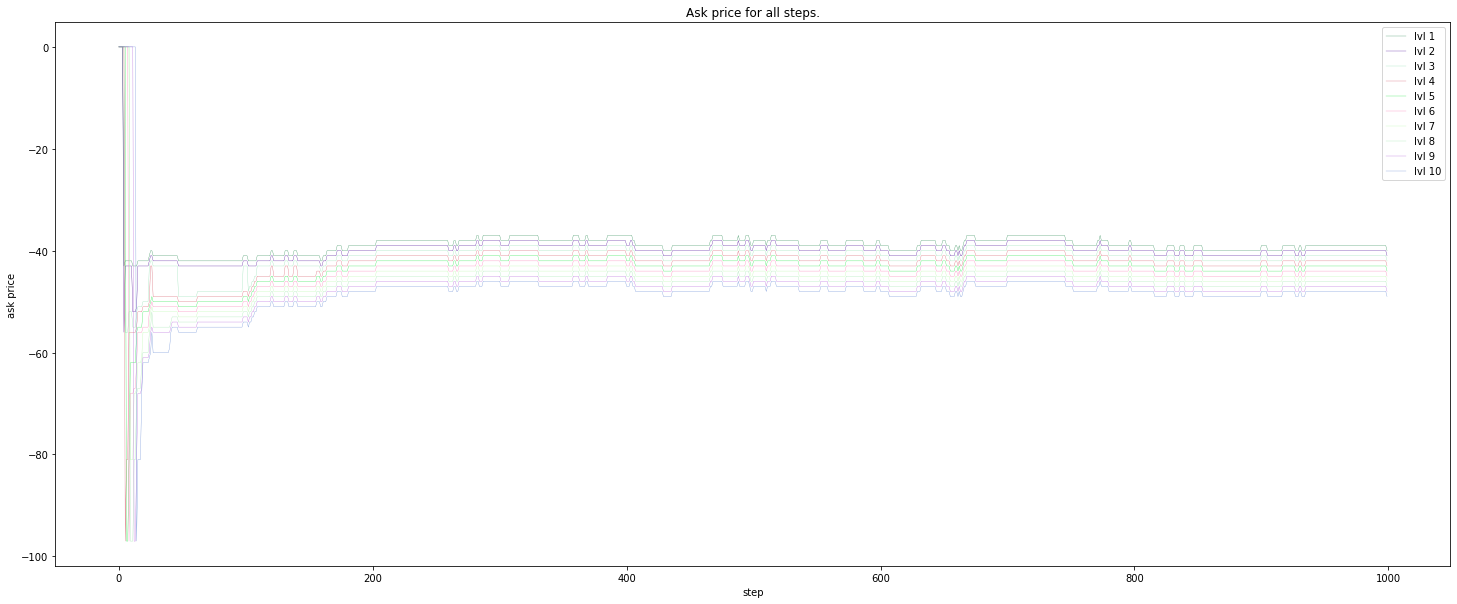

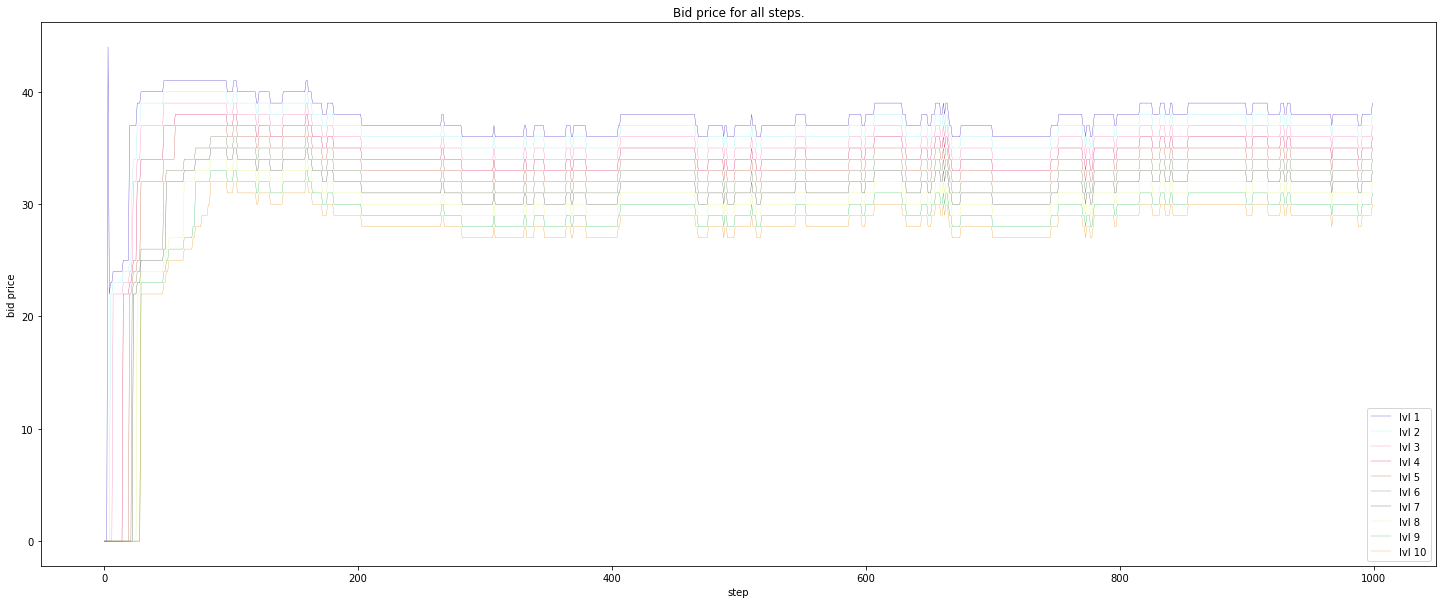

In [20]:
# Plot obs for all steps in last episode
show_obs(obs_store)